In [1]:
%reset -f

In [125]:
import gc
import numpy as np
from itertools import islice
from collections import Counter
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
gc.collect()

20938

In [3]:
with open('./dataset/corpus', 'rt') as fp:
    corpus = fp.read()

corpus = corpus.strip()
corpus = corpus.split()[:3000]
print(len(corpus))

3000


In [4]:
class SkipGramBatcher:
    def __init__(self, corpus, window_size=4, batch_size=32):
        '''corpus - list of words'''
        self.corpus = corpus
        self.window_size = window_size
        self.batch_size = batch_size
        self.make_vocab()
        return
    
    def make_vocab(self):
        self.vocab = sorted(set(corpus))
        self.V = len(self.vocab)
        self.word2index = {w: idx for idx, w in enumerate(self.vocab)}
        self.index2word = {idx: w for idx, w in enumerate(self.vocab)}
        return
    
    def batch_gen(self):
        '''c - corpus, v - vocab ; i - central, j - side'''
        x_batch = np.empty(self.batch_size, dtype=np.int)
        y_batch = np.empty(self.batch_size, dtype=np.int)
        curr_idx = 0
        for c_i, w in enumerate(self.corpus):
            v_i = self.word2index[w]
            window_left_border = c_i - self.window_size
            if window_left_border < 0:
                window_left_border = 0
            for side_w in self.corpus[window_left_border: c_i] \
                          + self.corpus[c_i + 1 : c_i + self.window_size + 1]:
                v_j = self.word2index[side_w]
                x_batch[curr_idx] = v_i
                y_batch[curr_idx] = v_j
                curr_idx += 1
                if curr_idx == self.batch_size:
                    curr_idx = 0
                    yield (x_batch, y_batch)
        # drop last
        #if curr_idx != 0:
            #yield (x_batch, y_batch)

In [5]:
def freq_filter(corpus, threshold):
    freq_map = Counter(corpus)
    filtrator = lambda w: 'UNK' if freq_map[w] <= threshold else w
    corpus = map(filtrator, corpus)
    return list(corpus)

In [6]:
#corpus = freq_filter(corpus, 1)
#corpus.count('UNK') / len(corpus)

In [7]:
batcher = SkipGramBatcher(corpus, batch_size=16)

In [8]:
V = batcher.V
N = 300
learning_rate = 1
print(V)
print(N)

model = torch.nn.Sequential( torch.nn.Linear(V, N, bias=False),
                             torch.nn.Linear(N, V, bias=False),
                             torch.nn.LogSoftmax(dim=1) )

984
300


In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
print_every = 1

In [11]:
def train(model, optimizer, epochs=1):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    """
    loss_values = []
    for e in range(epochs):
        
        loader_train = batcher.batch_gen()
        batch_size = batcher.batch_size
        epoch_loss = 0
        
        for t, (x_ids, y_ids) in enumerate(loader_train):

            model.train()  # put model to training mode
            
            input_buff = np.zeros((batch_size, V), dtype=np.float32)
            input_buff[np.arange(batch_size), x_ids] = 1

            x = torch.from_numpy(input_buff)
            y = torch.from_numpy(y_ids)

            scores = model(x)
            loss = torch.nn.functional.nll_loss(scores, y)
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if t % print_every == 0:
                #print('e: %d | batch: %d, loss = %.9f' % (e, t, loss.item())) # batch loss
                pass
        loss_values.append(epoch_loss)
        print('e: %d | loss = %.9f' % (e, epoch_loss))
    return loss_values

In [12]:
loss_values = train(model, optimizer, epochs=16)

e: 0 | loss = 9508.495482683
e: 1 | loss = 8775.927332163
e: 2 | loss = 8450.339711428
e: 3 | loss = 8140.524490833
e: 4 | loss = 7777.234580994
e: 5 | loss = 7398.077425003
e: 6 | loss = 7051.658417225
e: 7 | loss = 6779.250423670
e: 8 | loss = 6598.283614635
e: 9 | loss = 6492.662395239
e: 10 | loss = 6432.819865942
e: 11 | loss = 6394.943376780
e: 12 | loss = 6373.637499571
e: 13 | loss = 6355.536540985
e: 14 | loss = 6347.553528786
e: 15 | loss = 6340.218039036


It took a couple of minutes to train.

In [13]:
def plot_metric(x, y):
    plt.figure(figsize=(16, 8))
    plt.plot(x, y, 'o-', label='train')
    plt.xlabel('epochs')
    plt.ylabel('nll_loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

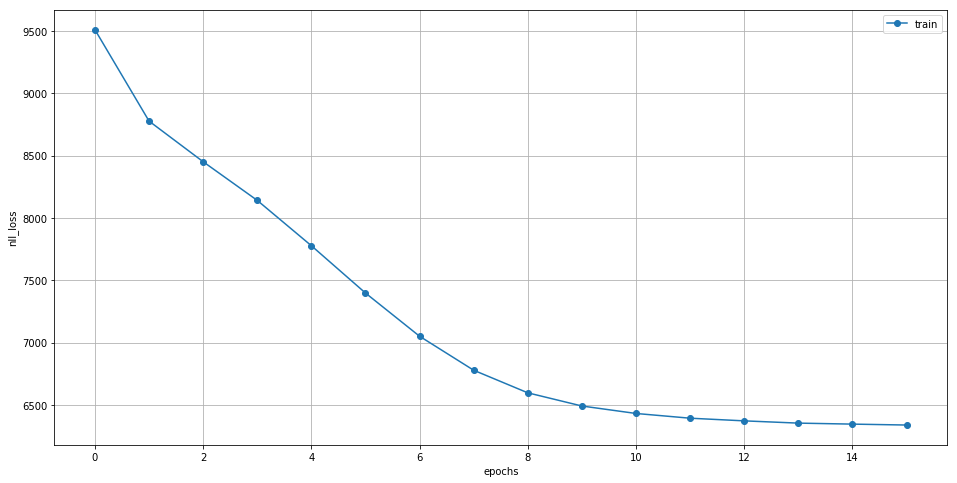

In [14]:
plot_metric(range(len(loss_values)), loss_values)

In [47]:
params = list(model.parameters())

In [126]:
W_2 = params[0].data.numpy()
W_1 = params[1].data.numpy()

In [172]:
def get_word_vector(token):
    '''function to map token to corresponding word vector'''
    idx = batcher.word2index[token]
    return W_1[idx]

### Plot vector progections of 50 most frequent words (beautiful visualization)

In [127]:
def reduce_to_k_dim(M, k=2):
    n_iter = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iter)
    M_reduced = svd.fit_transform(M)
    
    print("Done.")
    return M_reduced

In [60]:
W_reduced = reduce_to_k_dim(W_1)

Running Truncated SVD over 984 words...
Done.


In [128]:
def plot_embeddings(M_reduced, word2Ind, words):
    plt.figure(figsize=(16, 16))
    for w in words:
        idx = word2Ind[w]
        x, y = M_reduced[idx]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, w, fontsize=11)
    ax = plt.gca()
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    plt.grid()
    plt.show()

In [123]:
freq_map = Counter(corpus)
most_freq_words = sorted(freq_map.items(), key=lambda x: x[-1], reverse=True)
most_freq_words = list(zip(*most_freq_words))[0]

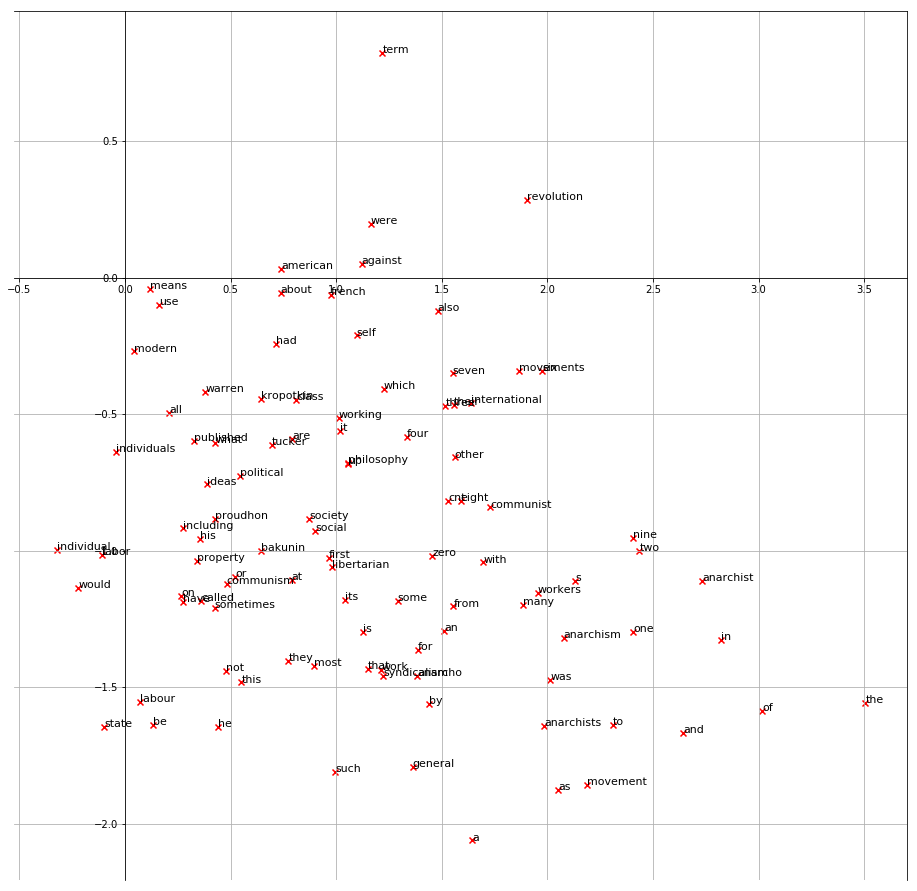

In [124]:
plot_embeddings(W_reduced, batcher.word2index, most_freq_words[:100])

### qualitative evaluations of word vectors: nearest neighbors, word analogies

In [265]:
def top_similar(token, n_similar):
    sim_matrix = cosine_similarity(W_1)
    idx = batcher.word2index['revolution']
    most_similar = np.argsort(sim_matrix[idx])[::-1][:n_similar]
    for w in [batcher.index2word[i] for i in most_similar]:
        print(w)

In [267]:
top_similar('revolution', 30)

revolution
the
key
in
anarchist
anarchists
and
one
to
s
february
of
latin
n
solidarity
mexican
seismic
uk
federation
anarchism
international
french
war
nine
organised
event
kronstadt
six
russian
movement


revolution: anarchists, february, war, organised, event, russian, movement

In [295]:
def solve_analogy(positive, negative, n_similar):
    pos_vec = [get_word_vector(w) for w in positive]
    neg_vec = [get_word_vector(w) for w in negative]

    vec = np.zeros(pos_vec[0].size)
    for v in pos_vec:
        vec += v
    for v in neg_vec:
        vec -= v
        
    sim_matrix = cosine_similarity(vec[np.newaxis, :] , W_1)
    most_similar = list(np.argsort(sim_matrix[0])[::-1])
    
    for w in positive + negative:
        most_similar.remove(batcher.word2index[w])
        
    for w in [batcher.index2word[i] for i in most_similar if len(batcher.index2word[i]) > 3][:n_similar]:
        print(w)

### a / b = x / y

In [328]:
a = 'anarchists'
b = 'chaos'
x = 'radicals'

In [329]:
positive = [x, b]
negative = [a]

anarchists : chaos :: radicals : anomie

In [330]:
solve_analogy(positive, negative, 20)

anomie
rather
nihilism
imply
levellers
louis
does
communistic
victory
destroy
culottes
organization
during
harmonious
armand
represented
pejorative
amount
politics
diggers
